In [1]:
import sys

sys.path.append('../')

In [2]:
import random
import functools

import PIL
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from typing import Tuple, Optional, Dict, Any, Collection, Callable

from PIL import Image as PIL_Image, ImageEnhance as PIL_ImageEnhance, \
                ImageDraw as PIL_ImageDraw, ImageFilter as PIL_ImageFilter
from core.aug.cracks import get_cracks

In [3]:
src_img = PIL_Image.open('../datasets/lfw/Aaron_Eckhart/Aaron_Eckhart_0001.jpg')
src_img_rgba = src_img.convert('RGBA')

In [4]:
def get_cracks_image(size: Tuple[int, int], crack_width: float = 1.0,
                     filling_ratio: Optional[float] = None,
                     **kwargs) -> PIL_Image.Image:
    source_size = [int(s / crack_width) for s in size]
    if filling_ratio is not None:
        # exact_end_dist correlates with the area occupied by the crack
        kwargs['exact_end_dist'] = filling_ratio * source_size[0] * source_size[1]
    mtx, _ = get_cracks(source_size, **kwargs)
    mtx *= 255
    rgba_mtx = np.array([mtx for _ in range(4)]).transpose(1, 2, 0)
    img = PIL_Image.fromarray(rgba_mtx, mode='RGBA').resize(size)
    return img


In [5]:
def draw_on_image(back_image: PIL_Image.Image, front_image_factory: Callable[..., PIL_Image.Image],
                  front_image_filters: Optional[Collection[PIL_ImageFilter.Filter]] = None,
                  **kwargs) -> PIL_Image.Image:
    size = back_image.size
    front_image = front_image_factory(size, **kwargs)
    if front_image_filters is not None:
        for filter_ in front_image_filters:
            front_image = front_image.filter(filter_)
    img = PIL_Image.alpha_composite(back_image, front_image)
    return img


In [6]:
def draw_cracks(img: PIL_Image.Image,
                cracks_image_filters: Optional[Collection[PIL_ImageFilter.Filter]] = None,
                **kwargs) -> PIL_Image.Image:
    return draw_on_image(img, get_cracks_image, cracks_image_filters, **kwargs)


CPU times: user 102 ms, sys: 1.47 ms, total: 104 ms
Wall time: 93.9 ms


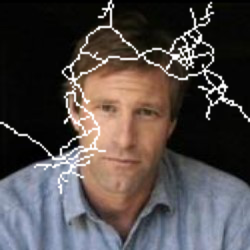

In [7]:
%%time
draw_cracks(src_img_rgba, crack_width=2.0, filling_ratio=0.05, angle_dist=100, fork_dist=10000)

In [8]:
def get_stains_image(size: Tuple[int, int], rgba_color: Tuple[int, int, int, int], d: int = 10,
                     d_scatter: int = 0, count: int = 10) -> PIL_Image.Image:
    assert len(size) == 2
    assert size[0] > 0 and size[1] > 0
    assert len([c for c in rgba_color if 0 <= c < 256]) == 4
    assert d > 0
    assert d_scatter >= 0
    assert count > 0

    img = PIL_Image.new('RGBA', size)
    ctx = PIL_ImageDraw.Draw(img)
    for _ in range(count):
        x0, y0 = random.randrange(-1 * d, size[0]), random.randrange(-1 * d, size[1])
        x1, y1 = x0 + d, y0 + d
        if d_scatter:
            x1 += random.randint(0, d_scatter)
            y1 += random.randint(0, d_scatter)
        ellipse_bb_coords = [(x0, y0), (x1, y1)]
        ctx.ellipse(ellipse_bb_coords, fill=rgba_color)
    return img


In [9]:
def draw_stains(img: PIL_Image.Image,
                stains_image_filters: Optional[Collection[PIL_ImageFilter.Filter]] = None,
                **kwargs) -> PIL_Image.Image:
    return draw_on_image(img, get_stains_image, stains_image_filters, **kwargs)


CPU times: user 920 µs, sys: 210 µs, total: 1.13 ms
Wall time: 1.09 ms


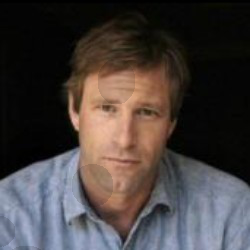

In [10]:
%%time
draw_stains(src_img_rgba, rgba_color=(0, 0, 0, 32), d=30, d_scatter=25, count=5)

CPU times: user 496 µs, sys: 0 ns, total: 496 µs
Wall time: 475 µs


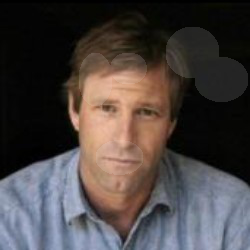

In [11]:
%%time
draw_stains(src_img_rgba, rgba_color=(255, 255, 255, 32), d=30, d_scatter=25, count=5)

CPU times: user 301 µs, sys: 0 ns, total: 301 µs
Wall time: 275 µs


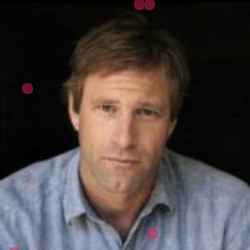

In [12]:
%%time
draw_stains(src_img_rgba, rgba_color=(210, 37, 87, 128), d=10, count=5)

In [13]:
_ccmtx = [
    0.393, 0.769, 0.189, 0,
    0.349, 0.686, 0.168, 0,
    0.272, 0.564, 0.131, 0,
]


def to_sepia(img: PIL_Image.Image, scatter: bool = True) -> PIL_Image.Image:
    ccmtx = [x + random.uniform(-0.01, 0.01) for x in _ccmtx]
    img = img.convert('RGB', ccmtx)
    return img


In [14]:
def alter_contrast(img: PIL_Image.Image) -> PIL_Image.Image:
    value = 0.55 + random.uniform(-0.5, 0.5) * 0.1
    img = PIL_ImageEnhance.Contrast(img).enhance(value)
    return img


In [15]:
def age(img, stains_kwargs: Dict[str, Any] = {}, cracks_kwargs: Dict[str, Any] = {}):
    img = to_sepia(img)

    img = img.convert('RGBA')
    c = random.randrange(0, 256)
    rgb = [c for _ in range(3)]
    img = draw_stains(img, rgba_color=(*rgb, 32), **stains_kwargs)
    img = draw_cracks(img, **cracks_kwargs)
    img = img.convert('RGB')

    img = alter_contrast(img)
    return img


CPU times: user 69.4 ms, sys: 0 ns, total: 69.4 ms
Wall time: 67.9 ms


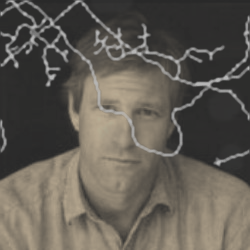

In [16]:
%%time
stains_kwargs = {
    'stains_image_filters': [PIL_ImageFilter.GaussianBlur(2)],
    'd': 25,
    'd_scatter': 10,
    'count': 10,
}

cracks_kwargs = {
    'cracks_image_filters': [
        PIL_ImageFilter.GaussianBlur(radius=1.6),
        PIL_ImageFilter.EDGE_ENHANCE_MORE,
    ],
    'crack_width': 2.0,
    'filling_ratio': 0.05,
    'angle_dist': 500,
    'fork_dist': 10000,
}

age(src_img, stains_kwargs=stains_kwargs, cracks_kwargs=cracks_kwargs)

In [17]:
cracks_img = get_cracks_image((250, 250), crack_width=2.0, filling_ratio=0.05, angle_dist=100, fork_dist=10000)

In [18]:
def f(filter_):
    cracks_img_filtered = cracks_img.filter(filter_)
    return PIL_Image.alpha_composite(src_img_rgba, cracks_img_filtered)


def fl(filters_):
    cracks_img_filtered = cracks_img
    for filter_ in filters_:
        cracks_img_filtered = cracks_img_filtered.filter(filter_)
    return PIL_Image.alpha_composite(src_img_rgba, cracks_img_filtered)


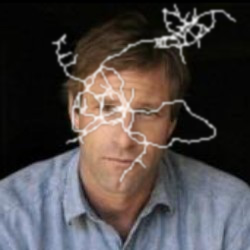

In [19]:
f(PIL_ImageFilter.GaussianBlur(radius=1.2))

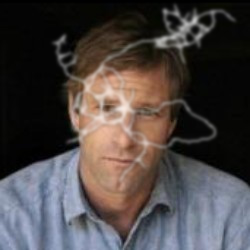

In [20]:
f(PIL_ImageFilter.GaussianBlur(radius=2))

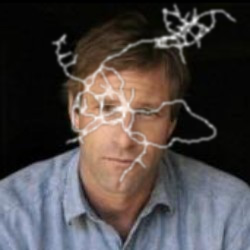

In [21]:
f(PIL_ImageFilter.BoxBlur(1.75))

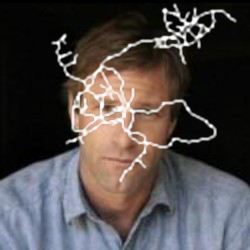

In [22]:
fl([
    PIL_ImageFilter.GaussianBlur(radius=1.6),
    PIL_ImageFilter.EDGE_ENHANCE_MORE,
])

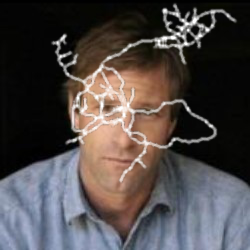

In [23]:
fl([
    PIL_ImageFilter.BoxBlur(1.75),
    PIL_ImageFilter.EDGE_ENHANCE,
])